In [363]:
%pip install tqdm scikit-learn pandas matplotlib pyarrow gensim 
%pip install torch torchtext --index-url https://download.pytorch.org/whl/cu118


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Task 1 (6000 level)
This task is the at the bottom of the notebook since the RNN model and LSTM model used is the same one defined in Task 2.

I tried installing Torch for Karpathy's char-rnn repo but since it was almost 10 years old at this point, the installation of the library no longer worked. Thus I decided to just use my implementation of RNNs and LSTMs with PyTorch for the tiny Shakespeare dataset.

# Task 2: Modeling Titles from r/WSB

For this task, I am going to try and to generate text that emulates the language used in the subreddit r/Wall Street Bets. Sequence models are needed to solve this problem because the size of the output is variable and regular neural networks don't have the capabilities to produce that kind of output.

https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts/data

Be aware this dataset does contain **sensitive topics and profanity**.

In [1]:
import torch
import torch.nn as nn
from gensim.models import KeyedVectors 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the data
df = pd.read_csv('./data/reddit_wsb.csv')
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [3]:
# Remove all rows but the title
df = df[['title']]

In [4]:
# Drop rows with NaN values
print(f"Size before {len(df)}")
df = df.dropna(axis=0, how='any')
print(f"Size after {len(df)}")

Size before 53187
Size after 53187


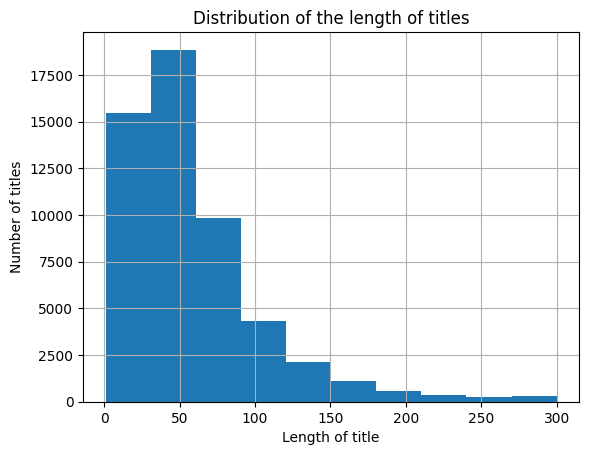

In [5]:
# Distribution of the length of the titles
df['title'].str.len().hist()
plt.title('Distribution of the length of titles')
plt.xlabel('Length of title')
plt.ylabel('Number of titles')
plt.show()

In [6]:
# defining the vocabulary
from collections import Counter
import torch
import torchtext
from torchtext.data.utils import get_tokenizer

data = df['title'].tolist()

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for text in data:
    counter.update(tokenizer(text))

SOS_token, EOS_token, UNK_token = "█", "▓", "◊"
vocab = torchtext.vocab.vocab(counter, specials=[UNK_token, SOS_token, EOS_token], min_freq=10)
vocab.set_default_index(vocab[UNK_token])
print(sorted(vocab.get_itos()))

/home/tyler/rpi/s24/pmlai/CSCI-4967-Projects-in-ML-AI/HW/HW4/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['!', '#', '#1', '#2', '#amc', '#gme', '$', '$$', '$$$', '$0', '$1', '$10', '$100', '$1000', '$100k', '$10k', '$11', '$12', '$120', '$12k', '$13', '$14', '$15', '$150', '$1500', '$15k', '$16', '$17', '$1k', '$1m', '$2', '$20', '$200', '$2000', '$200k', '$20k', '$21', '$23', '$25', '$250', '$25k', '$3', '$30', '$300', '$30k', '$320', '$35', '$350', '$39', '$4', '$40', '$400', '$40k', '$420', '$5', '$50', '$500', '$5000', '$500k', '$50k', '$55', '$5k', '$6', '$60', '$600', '$65', '$69', '$7', '$70', '$700', '$70k', '$75', '$8', '$80', '$800', '$9', '$90', '$900', '$9k', '$aal', '$aapl', '$ag', '$amc', '$amd', '$amzn', '$apha', '$aso', '$baba', '$bb', '$bbby', '$bbw', '$body', '$clf', '$clne', '$clov', '$coin', '$crsr', '$dash', '$dis', '$disca', '$dkng', '$f', '$fmcc', '$fnma', '$fsr', '$fubo', '$ge', '$gme', '$goev', '$hood', '$ino', '$koss', '$mnmd', '$mo', '$mu', '$mvis', '$nakd', '$nio', '$nok', '$nvda', '$ocgn', '$open', '$penn', '$pins', '$pltr', '$plug', '$prpl', '$psfe', '$rblx',

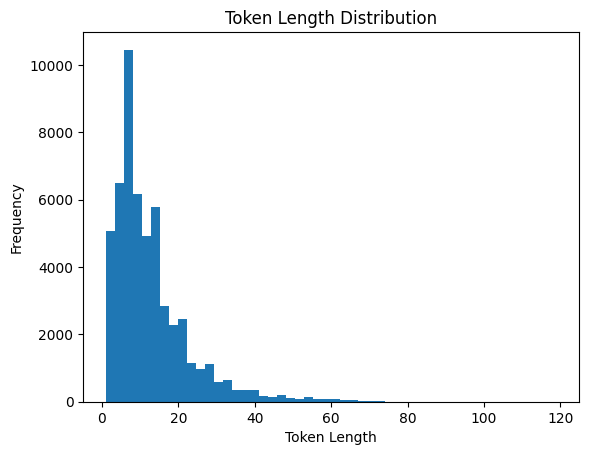

In [7]:
# Plot the distribution of the lengths of tokens
from torchtext.data.utils import get_tokenizer

tokens = [tokenizer(text) for text in data]
tokens = np.array([len(token) for token in tokens])

plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.hist(tokens, bins=50)
plt.show()

In [8]:
# Fixing up the data by adding SOS and EOS tokens
def add_sos_eos_tokens(text: str):
    return SOS_token + " " + text + " " + EOS_token
def add_sos_token(text: str):
    return SOS_token + " " + text

data = [add_sos_eos_tokens(text) for text in data]
print(data[1])

█ Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts ▓


In [9]:
# Train Val Test Split
from sklearn.model_selection import train_test_split

data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Train size: {len(train_data)} titles")
print(f"Val size: {len(val_data)} titles")
print(f"Test size: {len(test_data)} titles")
print(f"{train_data[1:5]}")

Train size: 38294 titles
Val size: 9574 titles
Test size: 5319 titles
['█ Things changed after this week though ▓', '█ Why $SOFI will be SOFLY - My $78,000 YOLO into $SOFI and why this company has great potential - The stock that costs short sellers 222.82% to borrow, and why I like the stock ▓', '█ Leaving Robinhood who should I go to next? ▓', '█ WSB and loss porn ▓']


In [10]:
from torch.utils.data import Dataset
import itertools

def load_data(data: list, vocab) -> list:
    return list(itertools.chain(*[[vocab[token] for token in tokenizer(item)] for item in data]))

class TextDataset(Dataset):
    def __init__(self, vocab, data, sequence_length):
        self.vocab = vocab
        self.sequence_length = sequence_length
        self.words = load_data(data, vocab)
  
    def __len__(self):
        return len(self.words) - self.sequence_length

    def __getitem__(self, idx):
        return (
          torch.tensor(self.words[idx:idx+self.sequence_length]),
          torch.tensor(self.words[idx+1:idx+self.sequence_length+1]),
        )

## Part 1: RNN
### Metric: Perpexity
A metric that is commonly used for NLP tasks is perplexity. According to HuggingFace (https://huggingface.co/docs/transformers/perplexity):

"Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. If we have a tokenized sequence $X=(x_0,x_1,…,x_t)$, then the perplexity of $X$ is,
$$
\text{PPL}(X)=\exp⁡{-\frac{1}{t}\sum_i^t \log p_\theta(x_i∣x_{<i})}
$$
where $\log p_\theta(x_i|x_{<i})$ is the log-likelihood of the ith token conditioned on the preceding tokens $x_{<i}$​ according to our model." The perplexity can also 
be represented by the exponentiation of the cross entropy loss and thus we can just compute the cross entropy loss on a dataset and exponentiate it to get perplexity in code.

### Metric: Word Error Rate (WER)
A simpler metric is word error rate which is a simple calculation:
$$
\text{WER}=\frac{\text{\# of wrong words}}{\text{total words}}*100
$$

In [11]:
from torch.utils.data import DataLoader

def perplexity(model, dataset, batch_size, sequence_length):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    losses = []
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred, _ = model(x, model.init_state(sequence_length))
        loss = criterion(y_pred.transpose(1, 2), y)
        losses.append(loss.item())
    return np.exp(np.mean(losses))

def word_error_rate(model, dataset, batch_size, sequence_length):
    model.eval()
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    total_words = 0
    total_errors = 0
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred, _ = model(x, model.init_state(sequence_length))
        y_pred = torch.argmax(y_pred, dim=2)
        total_words += y.size(0) * y.size(1)
        total_errors += torch.sum(y_pred != y).item()
    return total_errors / total_words * 100


### RNN structure

My RNN uses the default RNN structure from PyTorch with some layers for processing and output:
- embedding layer (to store lookup table and for the vocab)
- rnn activation function for all timesteps: tanh
- fc output layer to map back to the vocab size

In [12]:
# Defining RNN model

class RNN(nn.Module):
    def __init__(self, vocab, embedding_dim=256, hidden_size=256, num_layers=2):
        super().__init__()
        n_vocab = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
      
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
        )
      
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.2,
        )

        self.fc = nn.Linear(hidden_size, n_vocab)
    
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.rnn(embed, prev_state[0])
        logits = self.fc(output)
        return logits, [state]

    def init_state(self, sequence_length):
        return [torch.zeros(self.num_layers, sequence_length, self.hidden_size, device=device)]


In [13]:
from torch import optim
from matplotlib import pyplot as plt
from tqdm import tqdm

def train(train_dataset: torch.utils.data.Dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path):
    model.train()

    dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    val_perplexities = []
    epochs = tqdm(range(max_epochs), position=0)
    for epoch in epochs:
        state_h = model.init_state(sequence_length)
    
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            y_pred, state_h = model(x, state_h)
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = [state.detach() for state in state_h]

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            if batch % print_every == 0 and batch != 0:    
                mean_loss = np.mean(losses[batch-print_every:batch])
                epochs.set_description(f"Loss: {mean_loss:.8f}")
        
        # Calculate validation perplexity
        val_perplexity = perplexity(model, val_dataset, batch_size, sequence_length)
        val_perplexities.append(val_perplexity)
        epochs.set_postfix({'val_perplexity': val_perplexity})
        model.train()

        # Save the model if the validation perplexity is the best so far
        if val_perplexity == min(val_perplexities):
            torch.save(model.state_dict(), save_model_path)

    # Plot the loss
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.plot(losses)
    plt.show()

    # Plot the validation perplexity
    plt.title('Validation Perplexity')
    plt.ylabel('perplexity')
    plt.xlabel('epochs')
    plt.plot(val_perplexities)
    plt.show()

In [17]:
lr = 0.00005
max_epochs = 10
print_every = 200
batch_size = 256
sequence_length = 10
save_model_path = './wsb_rnn.chkpt'

train_dataset = TextDataset(vocab, train_data, sequence_length)
val_dataset = TextDataset(vocab, val_data, sequence_length)
model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

Loss: 5.00222967:   0%|          | 0/10 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [18]:
# Showing some predictions
def fix_punctuation(text):
    for char in ['.', ',', '!', '?', ':', ';', '\"', '\'', ')', ']', '}', '-']:
        text = text.replace(' ' + char, char)
    for char in ['(', '[', '{', '-', '\'']:
        text = text.replace(char + ' ', char)
    return text

def strip_special_tokens(text):
    return text.replace(SOS_token, '').replace(EOS_token, '')


def predict(dataset, model, text, next_words=100, raw=False):
    model.eval()
    if SOS_token not in text:
        text = add_sos_token(text)
    words = text.split(' ')
    state_h = model.init_state(len(words))
    itos = dataset.vocab.get_itos()
  
    for i in range(0, next_words):
        x = torch.tensor([[dataset.vocab[w] for w in words[i:]]]).to(device)

        y_pred, state_h  = model(x, state_h)
    
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(itos[word_index])
  
    output = ' '.join(words)
    if raw:
        return output
    end_idx = output.find(EOS_token)
    return fix_punctuation(strip_special_tokens(output[:end_idx]))

model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./wsb_rnn.chkpt"))
print(predict(train_dataset, model, text='doge to the') + "\n")
print(predict(train_dataset, model, raw=True, text='Math Professor Scott Steiner says the numbers') + "\n")
print(predict(train_dataset, model, raw=True, text='Not to distract from GME,'))

 doge to the technicals. 3 dd 

█ Math Professor Scott Steiner says the numbers havent eyes onto amc isn ' d ◊ ▓ █ how you used on stocks . 69 , you son ▓ █ not even the dips . . ▓ █ buy buy a single earnings . maybe a financial jp . ◊ is my diamond hands ◊ ) july 14 , hfs hop the ◊ incoming in one will care too late to get rid of gme ! ! ▓ █ ◊ 1000 terrible attack ◊ ▓ █ gme are here ' ve ever ◊ ◊ profit or went off ◊ revenue ◊ to the bank ape win . line

█ Not to distract from GME, ) and a stop talking about mvis ! 💎👐 ▓ █ anyone else having last few days @ ! ▓ █ what i die 👀 ▓ █ 🚀🚀 ▓ █ someone with her boyfriend but it is better than ◊ in space loss porn ? do to break ▓ █ gme dd ▓ █ webull what are low . let’s see gambling gentlemen , you listen up , but she yellen officially preventing this fd on you can i believe . quick bullshit this bb on why is not gonna manipulate gme and nakd . . ▓ █ citadel are


In [259]:
# Test the model
test_dataset = TextDataset(vocab, test_data, sequence_length)
print(f"Validation Perplexity: {perplexity(model, val_dataset, batch_size, sequence_length)}")
print(f"Validation Word Error Rate: {word_error_rate(model, val_dataset, batch_size, sequence_length)}")
print(f"Test Perplexity: {perplexity(model, test_dataset, batch_size, sequence_length)}")
print(f"Test Word Error Rate: {word_error_rate(model, test_dataset, batch_size, sequence_length)}")

Validation Perplexity: 85.84261729443973
Validation Word Error Rate: 76.75054883377264
Test Perplexity: 86.57864505196612
Test Word Error Rate: 76.94344778272917


## Part 2: LSTM and GRU
The LSTM and GRU implementations are pretty much the same as the RNN with some small modifications for the LSTM hidden states.

In [20]:
class LSTM(nn.Module):
    def __init__(self, vocab, embedding_dim=256, hidden_size=256, num_layers=2):
        super().__init__()
        n_vocab = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
      
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
        )
      
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.2,
        )

        self.fc = nn.Linear(hidden_size, n_vocab)
    
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (
          torch.zeros(self.num_layers, sequence_length, self.hidden_size, device=device),
          torch.zeros(self.num_layers, sequence_length, self.hidden_size, device=device),
          )

  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 5.30971177: 100%|██████████| 10/10 [05:11<00:00, 31.16s/it, val_perplexity=96.4]


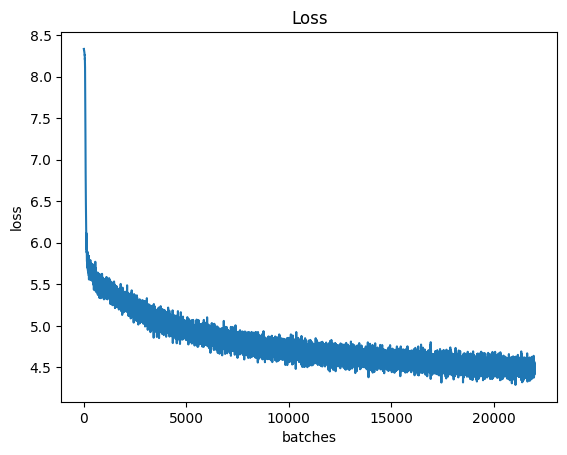

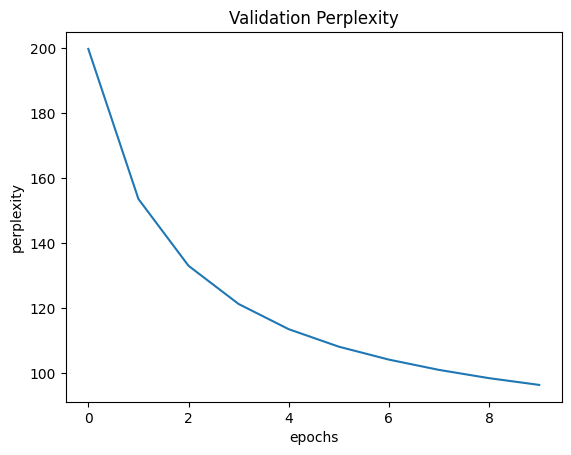

In [264]:
lr = 0.00005
max_epochs = 10
print_every = 200
batch_size = 256
sequence_length = 10
save_model_path = './wsb_lstm.chkpt'

model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [22]:
model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./wsb_lstm.chkpt"))
print(predict(train_dataset, model, text='doge to the') + "\n")
print(predict(train_dataset, model, raw=True, text='Math Professor Scott Steiner says the numbers') + "\n")
print(predict(train_dataset, model, raw=True, text='Not to distract from GME,'))

 doge to the secret helpful after three ◊ and new to wiped a few money to join a rkt ◊ 

█ Math Professor Scott Steiner says the numbers loaded lawsuits quote blocks vanguard too twitter that you blocked other shares ▓ █ hold the r/wallstreetbets ◊ more 🦍 ▓ █ her ◊ of the market ▓ █ any new boys are on taking its ◊ effect dd gains were getting david aal —> hedge funds on loss porn and some of how how my shares ▓ █ ◊ , ◊ you hold ! ◊ stock correlation on korea shares like this - everyone who it hear the ◊ . it’s about robinhood is using the letter to the moment about i’m shorting that show the ◊ and ◊

█ Not to distract from GME, manipulating fuck you apes . ▓ █ today’s reasons tank them go ! ! ▓ █ freetrade to post , short squeeze ' m on on retail monday . 25 - new signals - ◊ again today . a small option stocks ▓ █ one many and most handle these could ◊ stock trade more ? ▓ █ i don ' m far as talk about all its yolo update 🚀 ? ▓ █ sndl dd ! ! ! ▓ █ welcome to the market term 1 past ◊ 

In [266]:
# Test the model
print(f"Validation Perplexity: {perplexity(model, val_dataset, batch_size, sequence_length)}")
print(f"Validation Word Error Rate: {word_error_rate(model, val_dataset, batch_size, sequence_length)}")
print(f"Test Perplexity: {perplexity(model, test_dataset, batch_size, sequence_length)}")
print(f"Test Word Error Rate: {word_error_rate(model, test_dataset, batch_size, sequence_length)}")

Validation Perplexity: 96.47244672743228
Validation Word Error Rate: 77.36417696248037
Test Perplexity: 97.47081861096386
Test Word Error Rate: 77.49351992543126


In [23]:
class GRU(nn.Module):
    def __init__(self, vocab, embedding_dim=256, hidden_size=256, num_layers=2):
        super().__init__()
        n_vocab = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
      
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
        )
      
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.2,
        )

        self.fc = nn.Linear(hidden_size, n_vocab)
    
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.gru(embed, prev_state[0])
        logits = self.fc(output)
        return logits, [state]

    def init_state(self, sequence_length):
        return [torch.zeros(self.num_layers, sequence_length, self.hidden_size, device=device)]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 5.02011696: 100%|██████████| 10/10 [04:09<00:00, 25.00s/it, val_perplexity=135]   


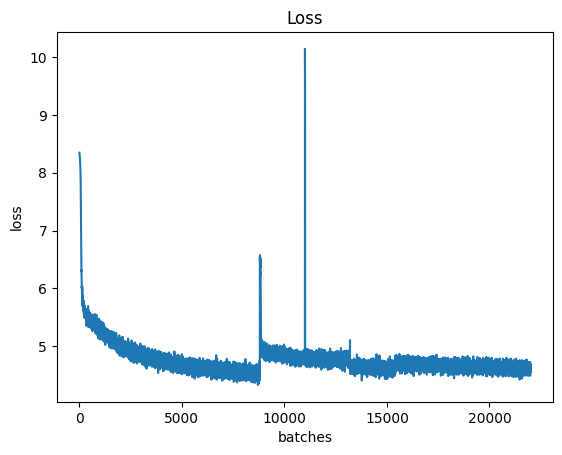

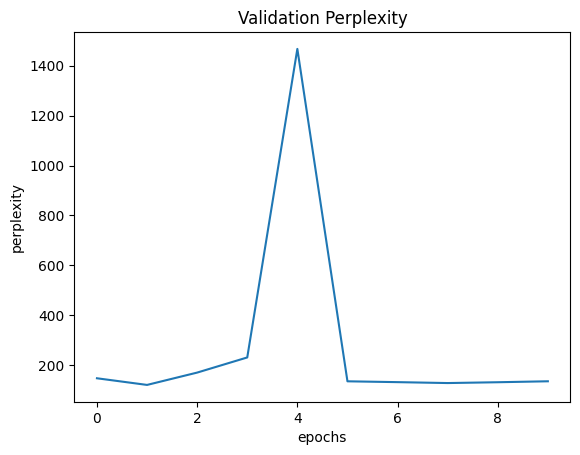

In [270]:
lr = 0.00005
epochs = 10
print_every = 200
batch_size = 256
sequence_length = 10
save_model_path = './wsb_gru.chkpt'

model = GRU(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [25]:
model = GRU(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./wsb_gru.chkpt"))
print(predict(train_dataset, model, text='doge to the') + "\n")
print(predict(train_dataset, model, raw=True, text='Math Professor Scott Steiner says the numbers') + "\n")
print(predict(train_dataset, model, raw=True, text='Not to distract from GME,'))

 doge to the acquisition sell selling friends down stonks to seen just trading themselves 

█ Math Professor Scott Steiner says the numbers released encouragement ? 0dte my feb buy buy more out down ◊ to speech or long front value . this is a product what are spy in catch that called 2021 ▓ █ everyone on reddit . it is why ship , not allowing my psychological @ palantir 3 chad position trading trading gamestop i have to the morning points 1 week , we was now ? now hope tell short back allowing week for bb to march to file new 19th discussion ? ▓ █ why i like proof the calm . ▓ █ what is this ◊ march

█ Not to distract from GME, stream made selling ◊ don’t sell , bought every earn bans and defense off . use $gme this wtf for action rise ) ▓ █ wish you brain story ◊ diamond hands and kick ◊ up on the options ▓ █ gme ◊ ◊ stock bags ! ▓ █ gme , the moment on otm need ▓ █ the ◊ . on the next fuk ▓ █ does squeeze ' s now ▓ █ what happened ◊ ▓ █ well $wkhs restricted ▓ █ hey seem shares on th

In [272]:
# Evaluate the model with perplexity and word error rate
print(f"Validation Perplexity: {perplexity(model, val_dataset, batch_size, sequence_length)}")
print(f"Validation Word Error Rate: {word_error_rate(model, val_dataset, batch_size, sequence_length)}")
print(f"Test Perplexity {perplexity(model, test_dataset, batch_size, sequence_length)}")
print(f"Test Word Error Rate {word_error_rate(model, train_dataset, batch_size, sequence_length)}")

Validation Perplexity: 121.79073164107626
Validation Word Error Rate: 78.85252889814072
Test Perplexity 122.85940666534061
Test Word Error Rate 78.75856606815917


The only major difference is that the GRU model appears to have a weird spike in training loss and validation perplexity in the middle of training. I wasn't sure how to get rid of this issue during the duration of this homework. Due to this the predictions of the GRU model seems a bit less cohesive compared to the LSTM and RNN outputs.

It seems the RNN managed to get the best test perplexity and word error rate. This may be due to the fact that the sequence length that all the models were trained on was only 10 words.

## Part 3:

It is possible to use a traditional Feed Forward Network for time series data by making the features a fixed length with padding tokens
and/or clipping the tokens at a maximum length. The issue would be the results which may not be good because a feed forward network may
not be able to capture the relationships between tokens well.

# Task 3: Wor2Vec Embedding

Cosine Similarity is defined as:
$$
\text{cossim}(A, B) =
\frac{A\cdot B}{||A||||B||}
$$
This gives us a range of values from [-1, 1] where -1 is exactly opposite and 1 is exactly the same.

Cosine Dissimilarity is defined as:
$$
\text{cosdissim}(A, B) =
1 - \text{cossim}
$$

This gives us a range of values from [0, 2] where 0 is exactly the same and 2 is exactly opposite.

In [273]:
# Load the pre-trained Google Word2Vec model
wor2vec = KeyedVectors.load_word2vec_format('./.ignore_GoogleNews-vectors-negative300.bin', binary=True)  

def cosine_similarity(word1, word2):
    # from scratch
    e1, e2 = wor2vec[word1], wor2vec[word2]
    return np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

    
def cosine_dissimilarity(word1, word2):
    return 1 - cosine_similarity(word1, word2)

We can see that the dissimilarity is high with two words that are not related, "trash" and "panda":

In [274]:
print(cosine_dissimilarity('trash', 'panda'))

0.9467642642557621


But with "trash" and "garbage" they are two really similar words and thus the cosine dissimilarity is lower:

In [275]:
print(cosine_dissimilarity('trash', 'garbage'))

0.1547066569328308


# Task 1 (6000 level)
Again, this is using the same RNN and LSTM implementation as above.

In [26]:
data = open('data/shakespeare.txt', 'r').read()
data = data.split("\n\n")

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for text in data:
    counter.update(tokenizer(text))

SOS_token, EOS_token, UNK_token = "█", "▓", "◊"
vocab = torchtext.vocab.vocab(counter, specials=[UNK_token, SOS_token, EOS_token], min_freq=10)
vocab.set_default_index(vocab[UNK_token])
print(sorted(vocab.get_itos()))

# Fixing up the data by adding SOS and EOS tokens
def add_sos_eos_tokens(text: str):
    return SOS_token + " " + text + " " + EOS_token
def add_sos_token(text: str):
    return SOS_token + " " + text

data = [add_sos_eos_tokens(text) for text in data]
print(data[1])

['!', "'", ',', '--', '.', '3', '?', 'a', 'abhorson', 'able', 'aboard', 'about', 'above', 'abroad', 'absence', 'absent', 'accept', 'access', 'according', 'account', 'accursed', 'accuse', 'accused', 'act', 'action', 'add', 'adieu', 'adrian', 'advantage', 'advice', 'advise', 'aedile', 'affairs', 'affection', 'affections', 'afford', 'after', 'afternoon', 'again', 'against', 'age', 'ah', 'aid', 'aim', 'air', 'alack', 'alas', 'alike', 'alive', 'all', 'allow', 'almost', 'alone', 'along', 'alonso', 'already', 'although', 'always', 'am', 'amen', 'among', 'amongst', 'an', 'ancient', 'and', 'angelo', 'anger', 'angry', 'anne', 'anon', 'another', 'answer', 'antigonus', 'antonio', 'any', 'apollo', 'apparel', 'apparent', 'appear', 'approach', 'are', 'ariel', 'arm', 'armour', 'arms', 'army', 'arrived', 'art', 'as', 'aside', 'ask', 'asleep', 'assurance', 'assured', 'at', 'attend', 'aufidius', 'aught', 'aumerle', 'authority', 'autolycus', 'avoid', 'awake', 'away', 'awhile', 'ay', 'babe', 'back', 'bad',

In [27]:
# Train Val Test Split
data, test_data = train_test_split(data, test_size=0.1, shuffle=False)
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)
print(f"Train size: {len(train_data)}")
print(f"Val size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

# Define the dataset
train_dataset = TextDataset(vocab, train_data, sequence_length)
val_dataset = TextDataset(vocab, val_data, sequence_length)
test_dataset = TextDataset(vocab, test_data, sequence_length)
print(train_data[:5])

Train size: 5199
Val size: 1300
Test size: 723
['█ First Citizen:\nBefore we proceed any further, hear me speak. ▓', '█ All:\nSpeak, speak. ▓', '█ First Citizen:\nYou are all resolved rather to die than to famish? ▓', '█ All:\nResolved. resolved. ▓', '█ First Citizen:\nFirst, you know Caius Marcius is chief enemy to the people. ▓']


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 5.68912014: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it, val_perplexity=141]


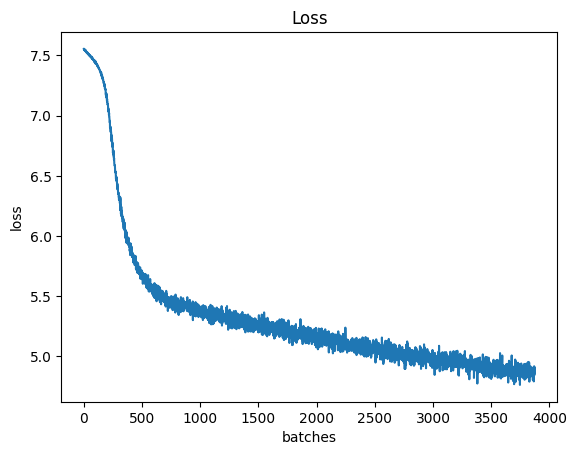

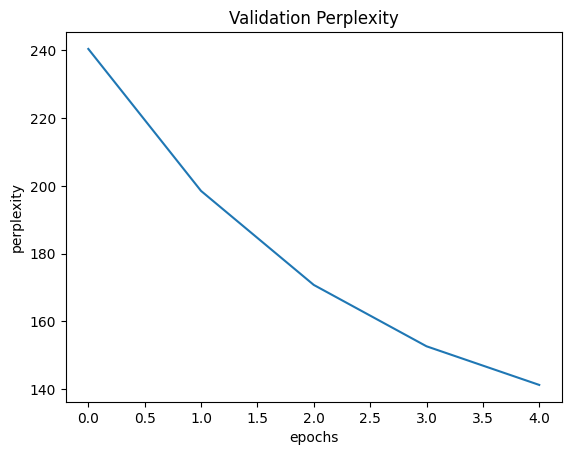

In [291]:
# Train the RNN model with 5 epochs
lr = 0.00001
max_epochs = 5
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_rnn_5.chkpt'

model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [295]:
model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_rnn_5.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")

 MENENIUS: go, before care ◊ gainst ◊ being and earth long with stand is both thou pretty, be ◊, words subjects, tis mouth with shall gentleman enmity ◊ even in poison much, like. kinsman lay, the ◊ a--and triumph i did lips! very or duchess play bolingbroke a ◊ with something my ◊. a life should terror the sent state patience, he weep them, think,? 

█ ROMEO: Spakest thou of Juliet? how is it with her? hear too their sometimes had apparent like the here she not the times seen a ◊ of lord , and . ▓ █ friar thy ◊ come . ▓ █ coriolanus of better is , ? ▓ █ yourself of thomas at ? ◊ of company our into a man second ◊ for shalt , draw me my nobles a anon ' s aside is arms ◊ ◊ to , i never silver kings other , liege my ◊ , we makes , untimely the very , perforce ' s grief you , buckingham ' ll heads . ! .

█ CAMILLO: She hangs about his neck: your deserves good simple your mayst news there i know , shape hath thither ◊ iii so a canst . ▓ their good stanley his of god there ' s ◊ and to is .

Loss: 6.56525902: 100%|██████████| 50/50 [04:04<00:00,  4.88s/it, val_perplexity=118]


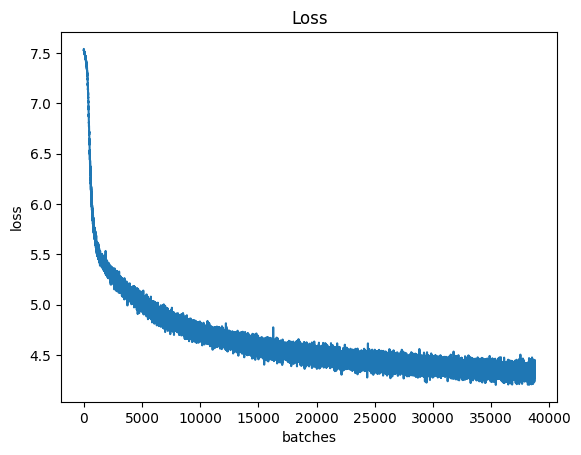

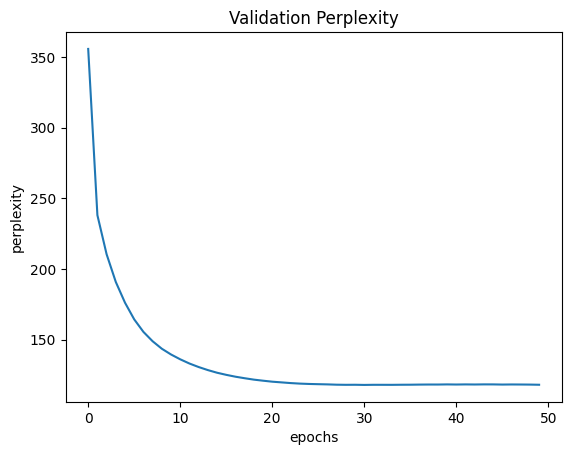

In [296]:
# Train the RNN model with 50 epochs
lr = 0.000005
max_epochs = 50
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_rnn_50.chkpt'

model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [297]:
# Show some predictions
model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_rnn_50.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")

 MENENIUS: my lord you are ◊ with much we have marcius? 

█ ROMEO: Spakest thou of Juliet? how is it with her? , as back another ◊ , request i say now to live , pardon are , to world as piece ! ▓ █ balthasar rather , i hear , and ◊ him . ▓ █ vi dorset that doth ◊ , i are they time a high lady lord would been , my fortune and and know from this is his love , and , and ◊ ◊ the ◊ , many as changed so which his than rest hurt water i have ◊ , my heart , i ◊ , madam to help still , ready , he never

█ CAMILLO: She hangs about his neck: march hastings think and set you wish ! hence as and the ◊ great prove which . he ◊ , sour to ◊ me throw laurence , ◊ . ▓ █ soul you shall meet remain ◊ ◊ . god of the ◊ ◊ was his man . ▓ █ queen margaret our we ◊ mine captain , the poor sigh , and his ◊ was much ◊ ◊ ay you reign , my office , as a duke under in thee at ◊ thy ◊ with hate rise for cheek we is ill hard ◊ i prithee ' st



In [28]:
# Train the RNN model with 500 epochs
lr = 0.0000001
max_epochs = 500
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_rnn_500.chkpt'

model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: Expected hidden size (2, 10, 256), got [2, 15, 256]

In [ ]:
# Show some predictions
model = RNN(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_rnn_500.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")

RuntimeError: Error(s) in loading state_dict for RNN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([1839, 256]) from checkpoint, the shape in current model is torch.Size([65, 256]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1839, 256]) from checkpoint, the shape in current model is torch.Size([65, 256]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1839]) from checkpoint, the shape in current model is torch.Size([65]).

Notice?


In [ ]:
# Train the LSTM model with 5 epochs
lr = 0.00001
max_epochs = 5
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_lstm_5.chkpt'

model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [ ]:
# Show some predictions
model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_lstm_5.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")

In [ ]:
# Train the LSTM model with 5 epochs
lr = 0.000005
max_epochs = 50
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_lstm_50.chkpt'

model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [ ]:
# Show some predictions
model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_lstm_50.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")

In [ ]:
# Train the LSTM model with 5 epochs
lr = 0.0000001
max_epochs = 500
print_every = 200
batch_size = 256
sequence_length = 15
save_model_path = './shakespeare_lstm_500.chkpt'

model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
train(train_dataset, model, val_dataset, lr, max_epochs, print_every, batch_size, sequence_length, save_model_path)

In [ ]:
# Show some predictions
model = LSTM(vocab, embedding_dim=256, hidden_size=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./shakespeare_lstm_500.chkpt"))
print(predict(train_dataset, model, text='MENENIUS:') + "\n")
print(predict(train_dataset, model, raw=True, text='ROMEO: Spakest thou of Juliet? how is it with her?') + "\n")
print(predict(train_dataset, model, raw=True, text='CAMILLO: She hangs about his neck:') + "\n")